In [15]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import root
from scipy import optimize
from eigenwell.src.constants import *

## Analytic solution for a dielectric 2d waveguide

In [23]:


def wg2(kzd, kz_max_d):
    '''
    :param kzd: kz*a transverse wavevector
    :param ei: slab dielectric
    :param e:  cladding dielectric
    :param kz_max_d: (k0**2*a**2*(e_i-e))
    :return:
    '''
    return np.tan(kzd) - np.sqrt(kz_max_d ** 2 - kzd ** 2) / kzd

def deriv_wg2(kz, kz_max):
    sec = lambda arg: 1/np.cos(arg)**2;
    arg = np.sqrt(kz_max**2 - kz**2);
    return sec(kz)**2 - (-2*kz**2/arg - arg)/kz**2





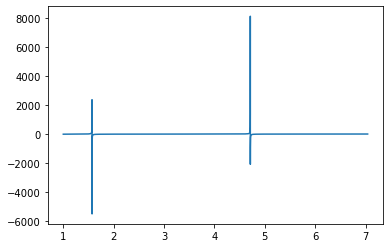

7.308360145442376
1.2966108742240579e-07


<ipython-input-23-048bb48c3dd8>:9: RuntimeWarning: invalid value encountered in sqrt
  return np.tan(kzd) - np.sqrt(kz_max_d ** 2 - kzd ** 2) / kzd
<ipython-input-23-048bb48c3dd8>:13: RuntimeWarning: invalid value encountered in sqrt
  arg = np.sqrt(kz_max**2 - kz**2);


In [24]:
## specify waveguide problem
L0 = 1e-6;
ei = 3;
e = 1;
a = 1;
wvlen = 10**-0.2; k0 = 2*np.pi/wvlen;
kz_max = np.sqrt(k0**2*a**2*(ei - e));

kz_test = np.linspace(1, kz_max/2, 10000);
plt.figure();
plt.plot(kz_test, wg2(kz_test, kz_max));
plt.show();

#kzn, history = nr.newton_root_args(wg2, deriv_wg2,  kz_max, x0=7.6, tol=1e-5, max_iter = 10000);
kzn = optimize.newton(wg2, x0 = 7.6, fprime=deriv_wg2, args = (kz_max,), maxiter = 10000)

print(kzn)
print(wg2(kzn, kz_max))

## do a scan of different frequencies

measured_beta = list();

# IF THE WVLEN IS TOO SMALL, THERE ARE TOO MANY POLES IN THE SCAN SPACE AND IT'S HARD TO GET A CLEAN SOLVE
wvlen_scan = np.linspace(2, 120, 700)

## need a good input guess in order to get the process started, so it's not a bad idea to look at the first wvlen
x0_guess =5

for lam0 in wvlen_scan :
    k0 = 2 * np.pi / lam0;
    kz_max = np.sqrt(k0 ** 2 * a ** 2 * (ei - e));

    #IF we return a NaN at any point, pick a different x_guess
    kzn = None;
    while(kzn is None):
        try:
            kzn = optimize.newton(wg2, fprime = deriv_wg2, args = (kz_max,), x0 = x0_guess, maxiter = 10000)
        except:
            kzn = None
            x0_guess = np.random.rand();
            pass
    
        #kzn = optimize.newton(wg2, fprime = deriv_wg2, args = (kz_max,), x0 = x0_guess, maxiter = 10000)

    x0_guess = kzn;
    beta = np.sqrt(k0**2*ei - kzn**2);
    measured_beta.append(beta);


plt.show();

Text(0, 0.5, 'omega')

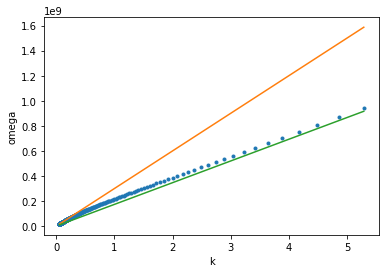

In [25]:
measured_beta = np.array(measured_beta);
c0 = 3e8;
omega_scan = 2*np.pi*c0/wvlen_scan;
plt.plot(measured_beta, omega_scan, '.');
plt.plot(measured_beta, c0 * measured_beta);
plt.plot(measured_beta, c0 * measured_beta/np.sqrt(ei));
plt.xlabel('k')
plt.ylabel('omega')



In [29]:

'''
functions to solve for the transcendental equation and reconstruct mode profiles for a 2d dielectric slab waveguide
'''

'''
In these functions, a is the waveguide HALF WIDTH, not the full width. 
so a corresponds to a waveguide that is 2a in width
'''
L0 = 1e-6;
mu0 = MU0*L0
eps0 = EPSILON0*L0
c0 = 1/sqrt(mu0*eps0)
epsilon_wg = 12;
epsilon_clad = 2;


def TE_even(k, a = 0.5, omega = 2*np.pi*c0/1.55, epsilon_wg = 6.25, epsilon_clad = 2.25):
    kmax = np.sqrt(omega**2*mu0*eps0*(epsilon_wg-epsilon_clad));
    return np.tan(k*a) - np.sqrt(kmax**2*a**2 - (k*a)**2)/(k*a)
    
def TE_odd(k, a = 0.5, omega = 2*np.pi*c0/1.55, epsilon_wg = 6.25, epsilon_clad = 2.25):
    kmax = np.sqrt(omega**2*mu0*eps0*(epsilon_wg-epsilon_clad));
    return -1/np.tan(k*a) - np.sqrt(kmax**2*a**2 - (k*a)**2)/(k*a)
  
#ansr = root(TE_even,  initial_guess)
  
def construct_mode_TE(k, a, omega, epsilon_wg, epsilon_clad, wrange, parity = 'even'):
    beta = np.sqrt(omega**2*mu0*eps0*epsilon_wg - k**2);
    kmax = np.sqrt(omega**2*mu0*eps0*(epsilon_wg-epsilon_clad));
    alpha = np.sqrt(kmax**2 - k**2)
    
    ## we need to know a priori from our problem set up how many grid points to do 
    wgx = np.linspace(-a, a, nwg);
    cladx_right = np.linspace(a, wrange[1], ncl//2+1)[1:];
    cladx_left = np.linspace(wrange[0], -a, ncl//2+2)[:-1]
    #assume Ey_eg coeff is 1
    if(parity == 'even'):
        Ey_wg = np.cos(k*wgx);
        Ey_clad_coeff = np.cos(k*a)/np.exp(-alpha*a);
    else:
        Ey_wg = np.sin(k*wgx);
        Ey_clad_coeff = np.sin(k*a)/np.exp(-alpha*a);

    Ey_clad_r = Ey_clad_coeff*np.exp(-alpha*cladx_right)
    Ey_clad_l = Ey_clad_coeff*np.exp(alpha*cladx_left)
    
    #Ey_wg, Ey_clad_l[:-1], Ey_clad_r[1:], wgx, cladx_left[:-1], cladx_right[1:];
    
    Ey_mode = np.concatenate((Ey_clad_l, Ey_wg, Ey_clad_r))
    xscan = np.concatenate((cladx_left, wgx, cladx_right))
    
    return xscan, Ey_mode, beta, kmax, alpha;

''' code snippet for calculating the bandstructure'''
## band structure scan using the band solver
import math
wvlen_scan = np.linspace(0.5,30,100);
wvlen_scan = np.logspace(np.log10(0.75), np.log10(30), 500);
omega_scan = 2*np.pi*c0/wvlen_scan;
## betax=2.422;%2.422;%2.179; #but we are solving for not betax, but k (or really kz)
for initial_guess in [0.2,4, 6]: ## warning higher order modes have CUTOFFS
    beta_data = list();
    odd_beta = list();
    ## DO THE TE even MODE
    for w in omega_scan:
        #does TE have a cutoff frequency, no, it shouldn't.
        def TE_even(k, a = 0.5, omega = w, epsilon_wg = 6.25, epsilon_clad = 2.25):
            kmax = np.sqrt(w**2*mu0*eps0*(epsilon_wg-epsilon_clad));
            return np.tan(k*a) - np.sqrt(kmax**2*a**2 - (k*a)**2)/(k*a)
        
        kmax = np.sqrt(w**2*mu0*eps0*(epsilon_wg-epsilon_clad));
        ansr = root(TE_even,  initial_guess)
        if(not ansr.success):
            beta_data.append(0);
            continue;
        #print(ansr.x[0])
        kans = ansr.x[0];

        alpha = np.sqrt(kmax**2 - kans**2)
        #beta = np.sqrt(w**2*mu0*eps0*epsilon_clad + alpha**2);
        beta_check = np.sqrt(w**2*mu0*eps0*epsilon_wg-kans**2);
        beta_data.append(beta_check);
    
    ## DO THE TE ODD MODE
    for w in omega_scan:
        def TE_odd(k, a = 0.5, omega = w, epsilon_wg = 6.25, epsilon_clad = 2.25):
            kmax = np.sqrt(omega**2*mu0*eps0*(epsilon_wg-epsilon_clad));
            return -1/np.tan(k*a) - np.sqrt(kmax**2*a**2 - (k*a)**2)/(k*a)
        ansr_odd = root(TE_odd,  initial_guess)
        if(not ansr_odd.success):
            odd_beta.append(0);
            continue;        
            
        kans = ansr_odd.x[0];
        alpha = np.sqrt(kmax**2 - kans**2)
        #beta = np.sqrt(w**2*mu0*eps0*epsilon_clad + alpha**2);
        beta = np.sqrt(w**2*mu0*eps0*epsilon_wg-kans**2);
        odd_beta.append(beta);
        
    beta_data = np.array(beta_data)
    plt.plot( omega_scan/(2*np.pi*c0), beta_data, '.b', markersize = 0.5)
    odd_beta = np.array(odd_beta);
 
    plt.plot( omega_scan/(2*np.pi*c0), odd_beta, '.g', markersize = 0.5)
  
    plt.ylabel("$\beta$")
    plt.xlabel("$\omega$"")
    
plt.plot(omega_scan/(2*np.pi*c0), 1.5*omega_scan/(c0), '--c')
plt.plot( omega_scan/(2*np.pi*c0), 2.5*omega_scan/(c0), '--c')
plt.show();

<ipython-input-29-12abd864fd5b>:95: RuntimeWarning: invalid value encountered in sqrt
  alpha = np.sqrt(kmax**2 - kans**2)
<ipython-input-29-12abd864fd5b>:88: RuntimeWarning: invalid value encountered in sqrt
  return -1/np.tan(k*a) - np.sqrt(kmax**2*a**2 - (k*a)**2)/(k*a)
<ipython-input-29-12abd864fd5b>:69: RuntimeWarning: invalid value encountered in sqrt
  return np.tan(k*a) - np.sqrt(kmax**2*a**2 - (k*a)**2)/(k*a)
<ipython-input-29-12abd864fd5b>:95: RuntimeWarning: invalid value encountered in sqrt
  alpha = np.sqrt(kmax**2 - kans**2)
<ipython-input-29-12abd864fd5b>:88: RuntimeWarning: invalid value encountered in sqrt
  return -1/np.tan(k*a) - np.sqrt(kmax**2*a**2 - (k*a)**2)/(k*a)
<ipython-input-29-12abd864fd5b>:69: RuntimeWarning: invalid value encountered in sqrt
  return np.tan(k*a) - np.sqrt(kmax**2*a**2 - (k*a)**2)/(k*a)
<ipython-input-29-12abd864fd5b>:95: RuntimeWarning: invalid value encountered in sqrt
  alpha = np.sqrt(kmax**2 - kans**2)
<ipython-input-29-12abd864fd5b>:8

ValueError: 
$eta$
^
Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 432x288 with 1 Axes>